# UX 10 Repeated Measures ANOVA

author:

    Sofia Dahl, sof@create.aau.dk\
    Dept. Architecture, Design and Media Technology, Aalborg University Copenhagen
---

## Learning goals

After working your way through this notebook you should be able to..
- Explain when to use repeated measures ANOVA
- Perform check of assumptions for repeated measures ANOVA
- Perform and interpret a one-way repeated measures ANOVA

  
## Table of Contents
- [1. Several dependent measures](#SeveralMeasures)
- [2. Assumptions for Repeated measures ANOVA](#assumptions)
    - [2.1 Normality](#normality)
    - [2.2 Sphericity](#sphericity)
- [3. One-way Repeated Measures ANOVA](#repANOVA)
    - [3.1 Within factors](#Withinfactors)
    - [ 3.2 Interpreting the Output](#interpret)
    - [3.3 Pairwise comparisons](#pairwise)
    - [3.4 Reporting results](#reporting) 
- [4. Choosing analysis](#choosing)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pingouin as pg

<a id= 'SeveralMeasures'> </a> 

## 1. Several dependent measures 
In many cases, we ask the same participant to participant in all the conditions because this reduces the effect of individual variability (as discussed in an earlier chapter). 
Whenever we have the same participant playing three instruments/games with different controllers, the data points are *related* because we repeated our measure for the same person. 

Let us set up some fictive data for this situation.

In [3]:
df = pd.DataFrame( {
    'Participant':        [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5],
    'Controller': ['W','X','Y','Z','W','X','Y','Z','W','X',
                       'Y','Z','W','X','Y','Z','W','X','Y','Z'],
    'Score':         [8,5,8,4,9,10,7,5,7,6,5,4,8,7,4,5,9,8,6,6]
} )
df.head()

,Participant,Controller,Score
0,1,W,8
1,1,X,5
2,1,Y,8
3,1,Z,4
4,2,W,9


Note that the first rows show data for the *same* participant. Since the same person tested several controllers the scores for the different controllers in our tests are *not* independent. We want to compare scores within the same participant for different controllers. We cannot use the classic ANOVA for this since it requires values to be independent. But multiple dependent t-tests are also increasing the risk of Type I errors. Instead we use repeated measures ANOVA as omnibus test.

Let's first have a look at what scores for the different controllers look like. 

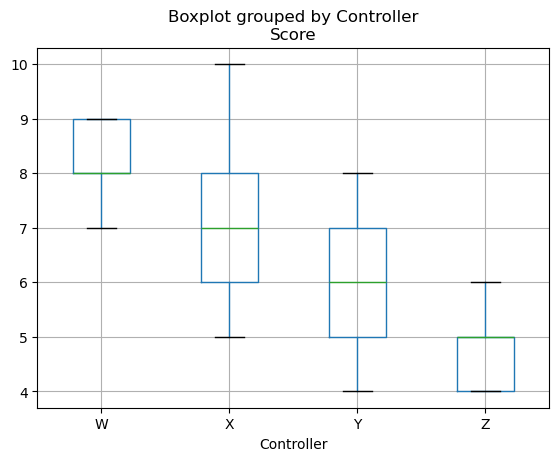

In [80]:
ax = df.boxplot(column=['Score'],by="Controller")
plt.show()

From the box plot we can see that there are some overlap between values for different controllers.

### Try out 1:
Recall what the different parts of the box plot stands for and reason about whether you expect to see significant differences in a test.

<a id= 'assumptions'> </a> 

## 2. Assumptions for Repeated measures ANOVA

Repeated measures ANOVA is a parametric test and also assumes data to come from normal distributions, but other assuptions differ compared to the classic ANOVA. In classic ANOVA it is important that values are independent, but in repeated measures ANOVA the whole point is that measures are  dependent. On the other hand, the data must be randomly sampled so that measures from DIFFERENT participants are not related. 

In classic ANOVA it is important that variability is approximately equal between groups. The box plot show that variability in data is different between controllers, but since we compare ratings for the same person, it is these differences that must be approximately equal in repeated measures ANOVA. This is called the assumption of shericity.  

<a id='normality'> </a>

### 2.1 Normality
To check whether data comes from a normal distribution we first do Q-Q plots for the scores of the different controllers. 

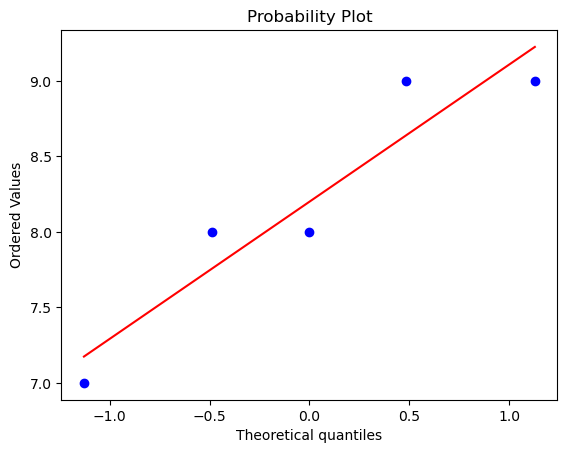

In [4]:
#Q-Q plots
stats.probplot(df[df['Controller']=='W'].Score, plot=plt);

plt.show() 

### Try out 2:
Plot and check Q-Q plots for the other three controllers as well.


In addition to the Q-Q plots we can use Shapiro-Wilk tests to test the null hypothesis that our data is drawn from a normal distribution.

In [94]:
# We can get several tests out at once 
stats.shapiro(df[df['Controller']=='W'].Score), stats.shapiro(df[df['Controller']=='X'].Score), stats.shapiro(df[df['Controller']=='Y'].Score), stats.shapiro(df[df['Controller']=='Z'].Score)

(ShapiroResult(statistic=0.8810376385817489, pvalue=0.3140395561440371),
 ShapiroResult(statistic=0.9787161500642191, pvalue=0.9276364233495382),
 ShapiroResult(statistic=0.986762155211559, pvalue=0.9671739349728582),
 ShapiroResult(statistic=0.8810376385817489, pvalue=0.3140395561440371))

Although W and Z do receive lower scores than the other controllers, it does not appear that the normality assumption is violated. 

<a id= 'sphericity'> </a>

### 1.2 Sphericity assumption

Similar to the paired t-test, a repeated measures ANOVA compares differences between scores for the same participant. This comparison relies on the assumption  of *sphericity*, that is that the variance of these differences are approximately equal. We test the null hypothesis that there is NO violation of sphericity with Mauchly's test. 

In [10]:

pg.sphericity( dv='Score', within='Controller', subject='Participant', method='mauchly', data=df )

SpherResults(spher=True, W=0.062100549562385504, chi2=7.565056754547511, dof=5, pval=0.20708214225927313)

 Had the assumption been violated, the usual procedure is to apply corrections to the data (typically Greenhouse-Geisser or Huynd-Feldt corrections is used in statistical softwares).

<a id= 'repANOVA'> </a> 

## 3. One-way Repeated Measures ANOVA

With the assumptions checked, we are now ready to set up our analysis. 


<a id= 'Withinfactors'> </a>

### 3.1 Within factors

The model we set up for repeated measures ANOVA is very similar to that of the classic 1-way ANOVA,

Score ~ Controller

but now we must also define a *within* factor. The software does not typically keep track of this unless we define it. In our example case, the within factor is the different controllers. That is, instead of having different groups contrasted, we now need to compare each individual participant's score in the different cases. 

Different software handles this in different ways and several (such as SPSS) require aggregated values in pivot tables for repeated measures. Statmodels in python has a particular class AnovaRM where this aggregation is taken care of.



<a id= 'interpreting'> </a>

### 3.2 Interpreting the Output

To run the repeated measures ANOVA we define the actual dependent variable, the within factor and which variable that has information on partipants.

In [21]:
pg.rm_anova(data=df, dv='Score', within='Controller', subject='Participant', detailed=False )

,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,Controller,3,12,5.117647,0.016501,0.430267,0.541199


Again, we get more output that we need in order to understand and interpret the data. 
- Source is the independent variable with the different controllers
- ddof1 are the degrees of freedom for the independent variable (how many controllers)
- ddof2 are the degrees of freedom for the dependent variable (the scores)
- F is the value of the F statistic
- p-unc is the uncorrected p-value telling us the probability of obtaining the F statistic given the H0
- ng2 is a measure of the effect size (generalized eta squared)
- eps is an index of sphericity, the closer to 1 the better.

So with this output, we have some information also on the size of the effect and whether the data is sound in terms of sphericity. Note that this is the less detailed output, the function can return several more measures (see help(pg.rm_anova) ).

The p-value indicates a main effect of controller so we should investigate what this comes from by using paired comparisons.

<a id= 'pairwise'></a> 

### 3.3 Pairwise comparisons

As in the other ANOVA, we need some tests that will help us understand what differences that contributed to the main effect. 

In [15]:

post_hocs = pg.pairwise_tests(dv='Score', within='Controller', subject='Participant', data=df)
post_hocs

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,Controller,W,X,True,True,0.301511,4.0,two-sided,0.778050,0.413,0.127735
1,Controller,W,Y,True,True,2.064187,4.0,two-sided,0.107939,1.291,1.068711
2,Controller,W,Z,True,True,10.614456,4.0,two-sided,0.000446,68.116,3.321121
3,Controller,X,Y,True,True,1.077632,4.0,two-sided,0.341851,0.607,0.615597
4,Controller,X,Z,True,True,3.538607,4.0,two-sided,0.024044,3.746,1.461491
5,Controller,Y,Z,True,True,1.394972,4.0,two-sided,0.235496,0.765,0.856875


The function returns paired compairisons with t-tests by default (so this is up to us to check, if data is *NOT* we should set the parametric=False and Mann-Whitney tests should be used.

In [56]:
#help(pg.pairwise_tests)

Based on this, the main effect is due to a difference between Controller W and Z. Looking back at the box plots, we can see that these are the scores that differ most from each other. However, we should calculate the mean and standard errors and estimate confidence intervals. 

In [129]:
#mean values grouped per controller
cont_mean=df[["Controller", "Score"]].groupby("Controller").mean()
cont_mean

,Score
Controller,
W,8.2
X,7.2
Y,6.0
Z,4.8


In [130]:
# standard error of mean for the different controllers
cont_sem=df[["Controller", "Score"]].groupby("Controller").sem()
cont_sem

,Score
Controller,
W,0.374166
X,0.860233
Y,0.707107
Z,0.374166


In [143]:
#We can now calculate confidence intervals
W_lo, W_hi =stats.t.interval(confidence=0.95, df=4, loc=cont_mean.iloc[0], scale=cont_sem.iloc[0])

print("95% confidence intervals for W:",W_lo, W_hi)

95% confidence intervals for W: [7.16114937] [9.23885063]


### Try out 3:
Proceed to calculate confidence intervals for the three other controllers and collect in a data frame. Compare to the box plot we plotted earlier. 

In [ ]:
# collecing upper and lower confidence intervals

#controllers = pd.DataFrame( {
#    'Controller': ['W','X','Y','Z'],
#    'Mean':         [cont_mean],
#    'Lower':       [W_lo, X_lo, Y_lo, Z_lo],
#    'Higher':       [W_hi, X_hi, Y_hi, Z_hi],
#} )


<a id= 'reporting'> </a> 

### 3.4 Reporting results

After all this analysis, we can finally report our results in style: 

A one-way repeated measures ANOVA on scores with controller as within factor showed a main effect of controller F(3,12)=5.12, p=0.02. Post-hoc pairwise comparisons revealed controller W (mean= 8.2, CI= 7.2-9.2) to receive higher scored than controller Z  (mean= 4.8, CI= xx-yy), t(4)=10.61 , p=0.0004.

Of course, it is always nice with a plot showing all the means and confidence intervals as well.

### Try out 4:
Place the correct values in the above text to complete the report of the results in written form.

### Try out 5:
Change the below code to plot all four controllers (using the new data frame you saved in Try out 3).

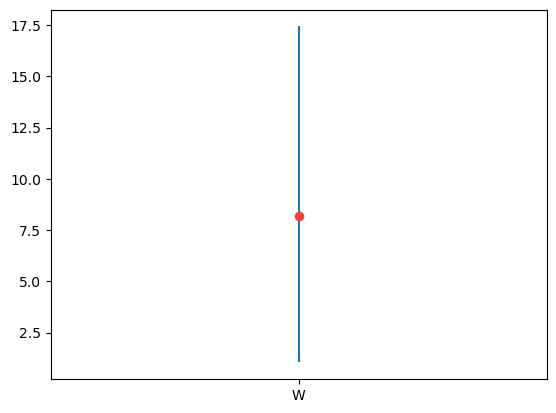

In [181]:
# Plot the controllers on X-axis and the mean and confidence intervals on the y-axis
plt.errorbar(df.Controller[0], cont_mean.iloc[0], yerr=[W_lo, W_hi]) #plot confidence intervals as error bars around mean
plt.plot(df.Controller[0], cont_mean.iloc[0], 'o', color='#f44336') # mark the mean value with a different colour
plt.show() 

<a id= 'choosing'> </a> 

## 4. Choosing analysis


We have now completed a classic one-way ANOVA and a one-way repeated measures ANOVA. Understanding what types of analysis that is suitable and how to interpret the results takes time to get acquainted with. There are practical flow-charts useful to find the right analysis for the type of data collected, like this supplied by Pingouin https://pingouin-stats.org/build/html/guidelines.html#anova

![flowchart_one_way_ANOVA](https://pingouin-stats.org/build/html/_images/flowchart_one_way_ANOVA.svg)

The examples we have worked with for classic ANOVA and repeated measures ANOVA are quite simple with only one factor (one-way). If we have more than one factor, we would have factorial ANOVA. This could, for instance have an additional hypothesis, that the scores might be affected by the level of experience or the type of instrument that participants were trained on. To investigate this, we add and additional independent variable "Instrument" where participants were recruited among different groups of instrumentalists. If we include three controllers and three different instrumentalists we would have a 2-way ANOVA. In addition to any *main effect* of instrument group or controller, it is also likely that we would like to investigate the  *interaction effects* where there is effect of the controller and instrument *combined*. This would be called a factorial 3 $\times$ 3 ANOVA.

There are two things to keep in mind when designing these kinds of studies:
- The more factors you involve, the more difficult it will be to interpret any interaction effects.
- The more factors, the more participants are needed in between-group studies.

With respect to participants, it could make sense to have the controller as a within factor, and have all participants from the three groups of instrumentalists try all kinds of controllers. This would be a 2-way Mixed ANOVA. 


As you probably have gathered by now, there are many different possibilities, and many things to be cautious about when setting up your test. You will have to consult other books for the details on these statistical methods. And when you do, also do yourself the favor of investigating that you are able to conduct the analysis (including assumptions check) within the software.